# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

## Описание проекта

Заказчик этого исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, нам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

### Бизнес-метрика и другие данные

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

### Описание данных

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:
- `id` — номер записи;
- `adults` — количество взрослых постояльцев;
- `arrival_date_year` — год заезда;
- `arrival_date_month` — месяц заезда;
- `arrival_date_week_number` — неделя заезда;
- `arrival_date_day_of_month` — день заезда;
- `babies` — количество младенцев;
- `booking_changes` — количество изменений параметров заказа;
- `children` — количество детей от 3 до 14 лет;
- `country` — гражданство постояльца;
- `customer_type` — тип заказчика:
    - `Contract` — договор с юридическим лицом;
    - `Group` — групповой заезд;
    - `Transient` — не связано с договором или групповым заездом;
    - `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
- `distribution_channel` — канал дистрибуции заказа;
- `is_canceled` — отмена заказа;
- `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
- `lead_time` — количество дней между датой бронирования и датой прибытия;
- `meal` — опции заказа:
    - `SC` — нет дополнительных опций;
    - `BB` — включён завтрак;
    - `HB` — включён завтрак и обед;
    - `FB` — включён завтрак, обед и ужин.
- `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
- `previous_cancellations` — количество отменённых заказов у клиента;
- `required_car_parking_spaces` — необходимость места для автомобиля;
- `reserved_room_type` — тип забронированной комнаты;
- `stays_in_weekend_nights` — количество ночей в выходные дни;
- `stays_in_week_nights` — количество ночей в будние дни;
- `total_nights` — общее количество ночей;
- `total_of_special_requests` — количество специальных отметок.

### План работ

- Откроем файлы и изучим данные.
- Сделаем предобработку и исследовательский анализ данных.
- Вычислим бизнес-метрику.
- Разработаем модели ML, проверим и выберем лучшую.
- Выявим признаки "ненадежного" клиента.
- Сделаем общий вывод.

## Обзор файлов с данными

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from tqdm.notebook import trange

Откроем файлы и изучим данные.

In [2]:
df_train = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')

In [3]:
df_train.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


In [4]:
df_test.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [6]:
df_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


При первичном анализе можно заметить аномальное значение колонки `babies` - 10 в тренировочных данных. Так же много колонок имеют неверный тип данных - float64, вместо int.

## Предобработка и исследовательский анализ данных

Проверим данные на пропуски и явные дубликаты.

In [7]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [8]:
print(df_train.isna().sum())

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


In [9]:
print(df_test.isna().sum())

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


Пропуски и явные дубликаты отсутствуют.

Колонки `adults`, `children` и `babies` не могут быть нулевые все вместе, проверим это.

In [10]:
filter = (df_train['adults'] == 0) & (df_train['children'] == 0) & (df_train['babies'] == 0)
df_train[filter]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
23770,31710,0,48.0,2016,February,9,21,2,4,0.0,...,0,0,0,B,2,0,Transient-Party,0,0,6
26878,34818,0,122.0,2016,May,19,5,2,4,0.0,...,0,0,0,E,3,0,Transient,0,0,6
26879,34819,0,122.0,2016,May,19,5,2,4,0.0,...,0,0,0,E,3,0,Transient,0,0,6
31570,39510,0,256.0,2016,August,35,21,3,5,0.0,...,0,0,0,A,1,0,Transient,0,0,8
41461,59858,0,0.0,2015,November,49,30,1,2,0.0,...,1,0,1,A,2,0,Transient,0,0,3
50744,69262,0,52.0,2016,April,18,30,2,4,0.0,...,0,0,0,E,2,0,Transient-Party,0,1,6
54881,73467,0,108.0,2016,July,28,5,2,5,0.0,...,0,0,0,A,0,0,Transient,0,0,7
56674,75308,0,4.0,2016,August,32,5,2,2,0.0,...,0,0,0,A,2,0,Transient,0,2,4
57390,76028,0,88.0,2016,August,34,16,0,4,0.0,...,0,0,0,D,5,0,Transient,0,2,4
58416,77078,0,36.0,2016,August,35,27,3,6,0.0,...,0,0,0,A,2,0,Transient,0,2,9


Заменим в этих строках значения `adults` на 1

In [11]:
df_train.loc[filter, 'adults'] = 1

Аналогично проверим тестовую выборку.

In [12]:
filter = (df_test['adults'] == 0) & (df_test['children'] == 0) & (df_test['babies'] == 0)
df_test[filter]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
18333,73610,0,55.0,2017,March,10,5,2,0,0.0,...,1,1,9,A,2,0,Transient,1,0,2
21214,86706,0,50.0,2017,March,9,1,0,3,0.0,...,0,0,0,A,1,0,Transient,0,1,3
25596,91088,0,33.0,2017,May,19,9,0,1,0.0,...,0,0,0,E,3,0,Transient,0,0,1
28463,93955,0,26.0,2017,June,25,19,1,4,0.0,...,0,0,0,D,2,0,Transient,0,1,5
28821,94313,0,107.0,2017,June,26,27,0,3,0.0,...,0,0,0,A,1,0,Transient,0,0,3
29808,95300,0,44.0,2017,July,28,15,1,1,0.0,...,0,0,0,A,2,0,Transient,0,0,2
30052,95544,0,2.0,2017,July,28,15,2,5,0.0,...,0,0,0,A,1,0,Transient-Party,0,1,7


In [13]:
df_test.loc[filter, 'adults'] = 1

Детям и младенцам не могут сдать номер без взрослых, проверим это тоже.

In [14]:
filter = (df_train['adults'] == 0) & ((df_train['children'] > 0) | (df_train['babies'] > 0))
df_train[filter]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
17540,25480,0,1.0,2015,August,33,10,1,1,0.0,...,0,0,0,B,1,0,Transient-Party,0,0,2
17598,25538,0,104.0,2015,August,33,11,0,3,0.0,...,0,0,0,B,1,0,Transient-Party,0,2,3
17982,25922,0,3.0,2015,August,34,16,2,0,0.0,...,0,0,0,B,1,0,Transient-Party,0,1,2
21556,29496,1,48.0,2015,October,43,19,1,3,0.0,...,0,0,0,B,0,0,Transient-Party,0,1,4
22516,30456,1,6.0,2015,December,51,13,1,0,0.0,...,0,0,0,B,0,0,Transient-Party,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64641,83365,0,109.0,2016,December,51,16,2,3,0.0,...,0,0,0,B,0,0,Transient,0,2,5
64751,83478,0,197.0,2016,December,52,21,1,4,0.0,...,0,0,0,A,7,0,Transient-Party,0,0,5
64882,83610,0,104.0,2016,December,53,25,2,1,0.0,...,0,0,0,B,1,0,Transient,0,2,3
64892,83620,0,104.0,2016,December,53,25,2,1,0.0,...,0,0,0,B,0,0,Transient,0,2,3


Скорее всего ошибка в данных, кто-то не внес данные по взрослым, можно было бы уточнить информацию у отеля. Т.к. нет возможности, проверим среднее взрослых с детьми и заменим на это значение.

In [15]:
df_train.query('children > 0 | babies > 0')['adults'].mean()

1.8830304581520347

Заменим данные по взрослым на 2.

In [16]:
df_train.loc[filter, 'adults'] = 2

Аналогично сделаем и для тренировочной выборки.

In [17]:
filter = (df_test['adults'] == 0) & ((df_test['children'] > 0) | (df_test['babies'] > 0))
df_test[filter]

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
7743,44932,1,111.0,2017,January,1,2,1,3,0.0,...,0,0,0,B,0,0,Transient,0,2,4
7751,44940,1,268.0,2017,January,1,2,1,4,0.0,...,0,0,0,B,0,0,Transient,0,1,5
8772,45961,1,148.0,2017,February,6,5,2,5,0.0,...,0,0,0,B,0,0,Transient,0,2,7
9243,46432,1,134.0,2017,February,8,22,2,4,0.0,...,0,0,0,B,0,0,Transient,0,1,6
9305,46494,1,148.0,2017,February,8,24,2,2,0.0,...,0,0,0,B,1,0,Transient,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30601,96093,0,296.0,2017,July,30,27,1,3,0.0,...,0,0,0,B,0,0,Transient,0,1,4
30654,96146,0,276.0,2017,July,31,30,2,1,0.0,...,0,0,0,B,1,0,Transient,0,2,3
30678,96170,0,291.0,2017,July,30,29,2,2,0.0,...,0,0,0,B,0,0,Transient,0,1,4
30815,96307,0,159.0,2017,July,31,31,1,3,0.0,...,0,0,0,A,1,0,Transient,0,1,4


In [18]:
df_test.query('children > 0 | babies > 0')['adults'].mean()

1.8864569083447333

In [19]:
df_test.loc[filter, 'adults'] = 2

Проверим колонку babies на аномальные значения.

In [20]:
df_train['babies'].unique()

array([ 0.,  1.,  2., 10.,  9.])

In [21]:
df_train.query('babies > 3')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,January,3,12,0,2,2.0,...,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11.0,2015,October,42,11,2,1,1.0,...,0,0,0,A,1,0,Transient-Party,0,0,3


9 и 10 младенцев с 1 и 2 взрослыми явно ошибка, всего 2 строчки - можно просто удалить их или заменить на среднее - 1. Заменим на среднее.

In [22]:
df_train.query('babies > 3')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22995,30935,0,37.0,2016,January,3,12,0,2,2.0,...,0,0,0,D,1,0,Transient,0,1,2
41528,59925,0,11.0,2015,October,42,11,2,1,1.0,...,0,0,0,A,1,0,Transient-Party,0,0,3


In [23]:
df_train.loc[df_train['babies'] > 3, 'babies'] = 1

In [24]:
df_train.query('babies > 3')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


Проверим количество записей с младенцами больше 1. Если их очень мало, то объединим данные и получим категориальные данные - нет (0) и есть (1) младенец. И переименуем колонку в has_babies

In [25]:
df_train.groupby('babies').count()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
babies,,,,,,,,,,,,,,,,,,,,,
0.0,64777,64777,64777,64777,64777,64777,64777,64777,64777,64777,...,64777,64777,64777,64777,64777,64777,64777,64777,64777,64777
1.0,449,449,449,449,449,449,449,449,449,449,...,449,449,449,449,449,449,449,449,449,449
2.0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [26]:
df_test.groupby('babies').count()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
babies,,,,,,,,,,,,,,,,,,,,,
0.0,32237,32237,32237,32237,32237,32237,32237,32237,32237,32237,...,32237,32237,32237,32237,32237,32237,32237,32237,32237,32237
1.0,171,171,171,171,171,171,171,171,171,171,...,171,171,171,171,171,171,171,171,171,171
2.0,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [27]:
df_train.loc[df_train['babies'] > 1, 'babies'] = 1
df_test.loc[df_test['babies'] > 1, 'babies'] = 1

In [28]:
df_train.rename(columns={'babies': 'has_babies'}, inplace=True)
df_test.rename(columns={'babies': 'has_babies'}, inplace=True)

In [29]:
df_train.groupby('has_babies').count()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
has_babies,,,,,,,,,,,,,,,,,,,,,
0.0,64777,64777,64777,64777,64777,64777,64777,64777,64777,64777,...,64777,64777,64777,64777,64777,64777,64777,64777,64777,64777
1.0,452,452,452,452,452,452,452,452,452,452,...,452,452,452,452,452,452,452,452,452,452


Приведем данные к правильным типам.

In [30]:
df_train.head(2)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2


In [31]:
df_train.dtypes

id                                  int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
has_babies                        float64
meal                               object
country                            object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
days_in_waiting_list                int64
customer_type                      object
required_car_parking_spaces         int64
total_of_special_requests         

In [32]:
float_col = ['lead_time', 'adults', 'children', 'has_babies']

In [33]:
df_train[float_col] = df_train[float_col].astype('int64')

In [34]:
df_test[float_col] = df_test[float_col].astype('int64')

In [35]:
df_train.dtypes

id                                 int64
is_canceled                        int64
lead_time                          int64
arrival_date_year                  int64
arrival_date_month                object
arrival_date_week_number           int64
arrival_date_day_of_month          int64
stays_in_weekend_nights            int64
stays_in_week_nights               int64
adults                             int64
children                           int64
has_babies                         int64
meal                              object
country                           object
distribution_channel              object
is_repeated_guest                  int64
previous_cancellations             int64
previous_bookings_not_canceled     int64
reserved_room_type                object
booking_changes                    int64
days_in_waiting_list               int64
customer_type                     object
required_car_parking_spaces        int64
total_of_special_requests          int64
total_nights    

Проверим данные на неявные дубликаты и возможные ошибки в категориальных признаках.

In [36]:
for col in df_train.select_dtypes(include=['object']).columns:
    print(col, '\n', df_train[col].unique())

arrival_date_month 
 ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
meal 
 ['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
country 
 ['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN

Как можно заметить в колонках meal и reserved_room_type имеем много лишних пробелов в данных, а так же неявные дубликаты. Исправим это.

In [37]:
df_train['meal'] = df_train['meal'].str.strip()
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.strip()

In [38]:
df_test['meal'] = df_test['meal'].str.strip()
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()

In [39]:
for col in df_train.select_dtypes(include=['object']).columns:
    print(col, '\n', df_train[col].unique())

arrival_date_month 
 ['July' 'August' 'September' 'October' 'November' 'December' 'January'
 'February' 'March' 'April' 'May' 'June']
meal 
 ['BB' 'FB' 'HB' 'SC']
country 
 ['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 

Отлично, избавились от пробелов и неявных дубликатов.

In [40]:
df_train.head(2)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7,2015,July,27,1,0,1,1,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14,2015,July,27,1,0,2,2,...,0,0,0,A,0,0,Transient,0,1,2


Перведем месяцы в числовые значения.

In [41]:
months = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

In [42]:
df_train['arrival_date_month'] = df_train['arrival_date_month'].apply(lambda x: months[x])
df_test['arrival_date_month'] = df_test['arrival_date_month'].apply(lambda x: months[x])

In [43]:
df_train.head(2)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7,2015,7,27,1,0,1,1,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14,2015,7,27,1,0,2,2,...,0,0,0,A,0,0,Transient,0,1,2


Рассмотрим метрику `country`.

In [44]:
df_train['country'].unique().shape

(155,)

In [45]:
df_test['country'].unique().shape

(143,)

In [46]:
df_train['country'].value_counts(normalize=True).head(20)

PRT    0.441997
FRA    0.091585
GBR    0.078324
ESP    0.075120
DEU    0.059590
ITA    0.035674
IRL    0.022153
BEL    0.019087
NLD    0.017875
BRA    0.016680
USA    0.015453
CHE    0.013399
AUT    0.010977
SWE    0.008340
POL    0.008141
CHN    0.008064
CN     0.007481
ISR    0.005749
RUS    0.004538
NOR    0.004001
Name: country, dtype: float64

In [47]:
print(df_train['country'].value_counts(normalize=True).head(10).sum())

0.8580845942755522


Имеем очень большое количество значений. 85% данных находятся в топ-10 значений. Чтобы не плодить огромное количество лишних категорий оставим топ-10 значений, а остальные переведем в одну категорию - `other`.

In [48]:
top_country = df_train['country'].value_counts(normalize=True).head(10)
print(top_country.index)

Index(['PRT', 'FRA', 'GBR', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'NLD', 'BRA'], dtype='object')


In [49]:
df_train['country'] = df_train['country'].apply(lambda x: x if x in top_country.index else 'other')

In [50]:
df_test['country'] = df_test['country'].apply(lambda x: x if x in top_country.index else 'other')

In [51]:
df_train['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'other', 'DEU', 'BEL', 'NLD',
       'ITA', 'BRA'], dtype=object)

### Анализ отмен брони

Проверим количество отмен по разным категориям данных.

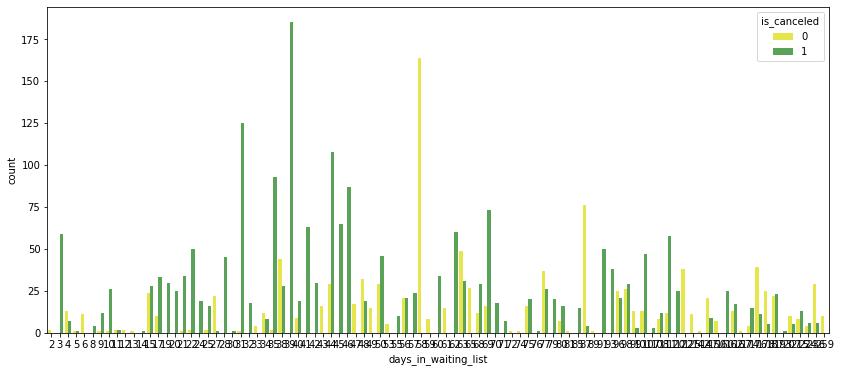

In [52]:
plt.figure(figsize=(14,6))
_ = sns.countplot(
    data=df_train.query('days_in_waiting_list > 1'),
    x='days_in_waiting_list',
    hue='is_canceled',
    palette='Set1_r')

In [53]:
df_train.query('days_in_waiting_list > 1')['is_canceled'].value_counts()

1    2119
0    1102
Name: is_canceled, dtype: int64

Как можно заметить если заказ не подтвержден в первые дни, то отмен в два раза больше.

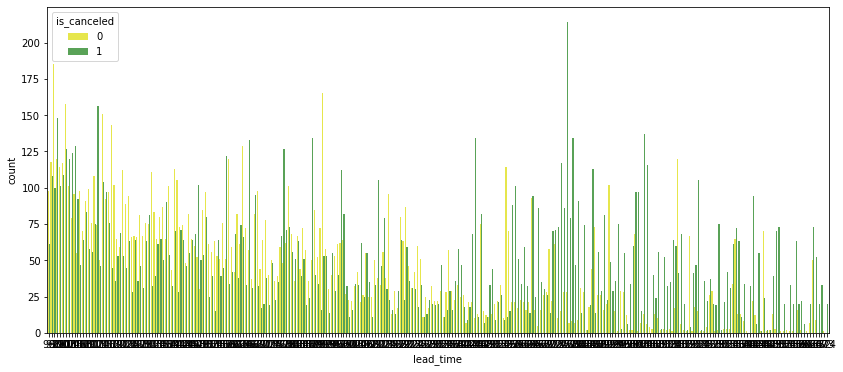

In [54]:
plt.figure(figsize=(14,6))
_ = sns.countplot(
    data=df_train.query('lead_time > 95'),
    x='lead_time',
    hue='is_canceled',
    palette='Set1_r')

In [55]:
df_train.query('lead_time > 95')['is_canceled'].value_counts()

1    13288
0    11814
Name: is_canceled, dtype: int64

Если время между бронированием и датой заезда больше 90 суток, то процент отмен увеличивается пропорционально.

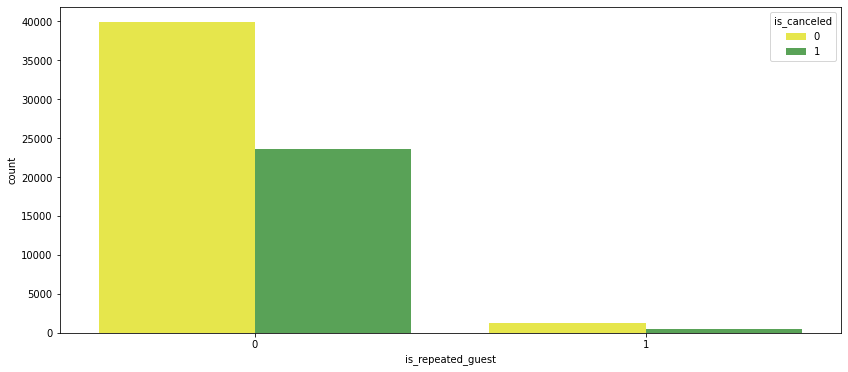

In [56]:
plt.figure(figsize=(14,6))
_ = sns.countplot(
    data=df_train,
    x='is_repeated_guest',
    hue='is_canceled',
    palette='Set1_r')

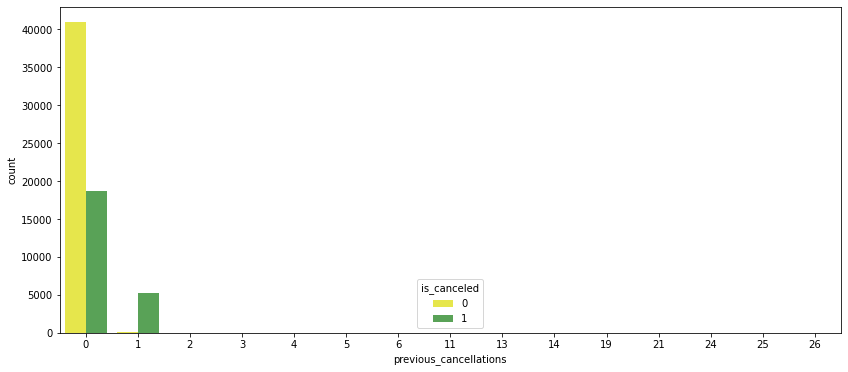

In [57]:
plt.figure(figsize=(14,6))
_ = sns.countplot(
    data=df_train,
    x='previous_cancellations',
    hue='is_canceled',
    palette='Set1_r')

In [58]:
df_train.query('previous_cancellations > 0')['is_canceled'].value_counts()

1    5396
0     242
Name: is_canceled, dtype: int64

Если у клиента есть отменённые заказы, то вероятность отмены почти 95%.

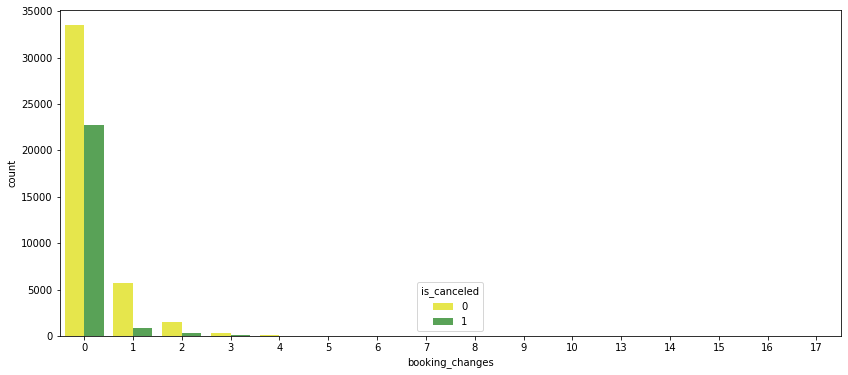

In [59]:
plt.figure(figsize=(14,6))
_ = sns.countplot(
    data=df_train,
    x='booking_changes',
    hue='is_canceled',
    palette='Set1_r')

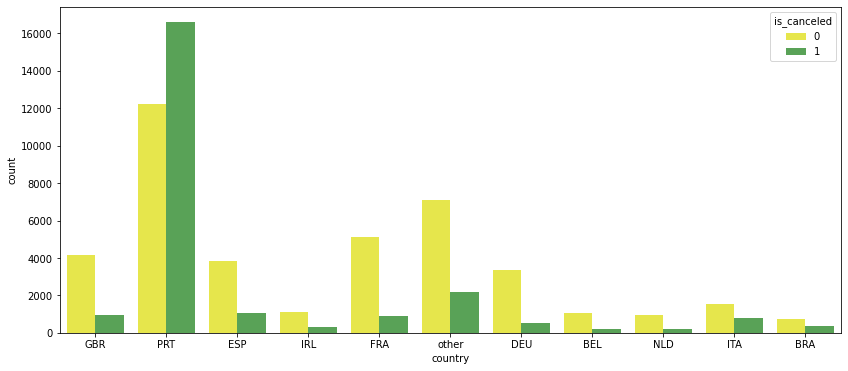

In [60]:
plt.figure(figsize=(14,6))
_ = sns.countplot(
    data=df_train,
    x='country',
    hue='is_canceled',
    palette='Set1_r')

Больше всего отмен у клиентов из Португалии.

In [61]:
df_train.dtypes

id                                 int64
is_canceled                        int64
lead_time                          int64
arrival_date_year                  int64
arrival_date_month                 int64
arrival_date_week_number           int64
arrival_date_day_of_month          int64
stays_in_weekend_nights            int64
stays_in_week_nights               int64
adults                             int64
children                           int64
has_babies                         int64
meal                              object
country                           object
distribution_channel              object
is_repeated_guest                  int64
previous_cancellations             int64
previous_bookings_not_canceled     int64
reserved_room_type                object
booking_changes                    int64
days_in_waiting_list               int64
customer_type                     object
required_car_parking_spaces        int64
total_of_special_requests          int64
total_nights    

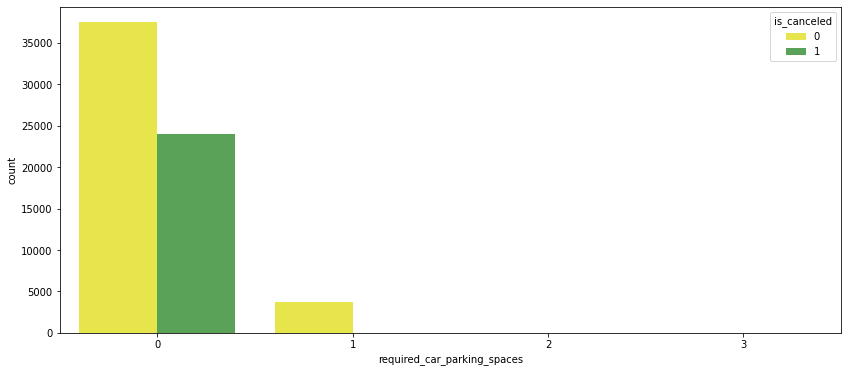

In [62]:
plt.figure(figsize=(14,6))
_ = sns.countplot(
    data=df_train,
    x='required_car_parking_spaces',
    hue='is_canceled',
    palette='Set1_r')

In [63]:
df_train.query('required_car_parking_spaces > 0')['is_canceled'].value_counts()

0    3682
Name: is_canceled, dtype: int64

Кто дополнительно заказывал паркинг - вообще не отменяли бронь.

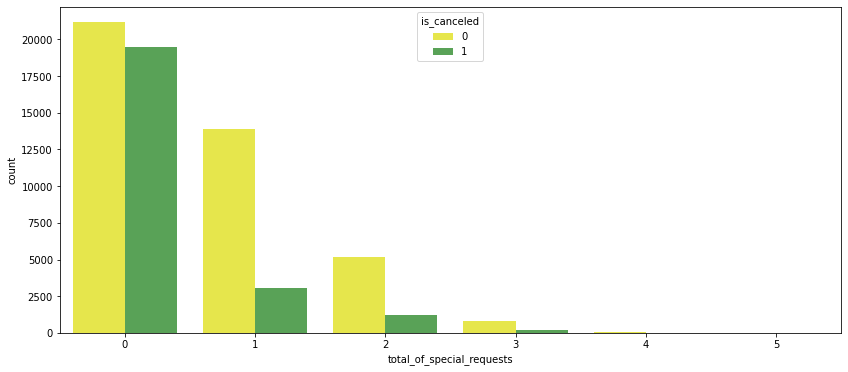

In [64]:
plt.figure(figsize=(14,6))
_ = sns.countplot(
    data=df_train,
    x='total_of_special_requests',
    hue='is_canceled',
    palette='Set1_r')

In [65]:
df_train.query('total_of_special_requests > 0')['is_canceled'].value_counts()

0    20015
1     4543
Name: is_canceled, dtype: int64

Если есть дополнительные опции/отметки то отмен всего ~20%

### Сбалансированность классов

Проверим сбалансированность классов в таргете.

In [66]:
df_train['is_canceled'].value_counts()

0    41185
1    24044
Name: is_canceled, dtype: int64

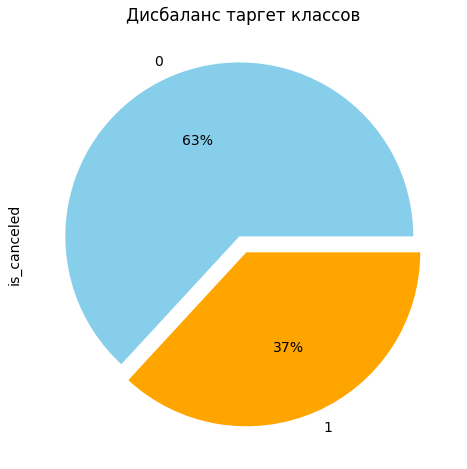

In [67]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(8, 8))
df_train['is_canceled'].value_counts().plot(
    kind='pie',
    autopct='%1.0f%%',
    colors=['skyblue', 'orange'],
    explode=(0.05, 0.05))
plt.title('Дисбаланс таргет классов')
plt.show()

Имеем небольшой дисбаланс классов 63/37.

Удалим малоинформативный признак `id` и `arrival_date_year`.

In [68]:
df_train.drop(columns=['id', 'arrival_date_year'], axis=1, inplace=True)
df_test.drop(columns=['id', 'arrival_date_year'], axis=1, inplace=True)

Судя по описанию данных total_nights, это сумма stays_in_weekend_nights и stays_in_week_nights. Все три признака нам не нужны, проверим и избавимся от лишних.

In [69]:
df_train.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7,7,27,1,0,1,1,0,0,...,0,0,0,A,0,0,Transient,0,0,1
1,0,14,7,27,1,0,2,2,0,0,...,0,0,0,A,0,0,Transient,0,1,2
2,0,0,7,27,1,0,2,2,0,0,...,0,0,0,C,0,0,Transient,0,0,2
3,0,9,7,27,1,0,2,2,0,0,...,0,0,0,C,0,0,Transient,0,1,2
4,1,85,7,27,1,0,3,2,0,0,...,0,0,0,A,0,0,Transient,0,1,3


In [70]:
(df_train['total_nights'] == df_train['stays_in_weekend_nights'] + df_train['stays_in_week_nights']).sum()

65229

In [71]:
df_train.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1, inplace=True)
df_test.drop(columns=['stays_in_weekend_nights', 'stays_in_week_nights'], axis=1, inplace=True)

In [72]:
df_train.head(2)

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,has_babies,meal,country,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,7,7,27,1,1,0,0,BB,GBR,...,0,0,0,A,0,0,Transient,0,0,1
1,0,14,7,27,1,2,0,0,BB,GBR,...,0,0,0,A,0,0,Transient,0,1,2


После удаления колонки с id, проверим данные на дубликаты, возможно одинаковые данные попадали в базу из разных источников под разными id и есть дубликаты. Удалим их, если есть.

In [73]:
print(df_train.duplicated().sum())
print('Процент дубликатов: {:.0%}'.format(df_train.duplicated().sum() / df_train.shape[0]))

print(df_test.duplicated().sum())
print('Процент дубликатов: {:.0%}'.format(df_test.duplicated().sum() / df_test.shape[0]))

21575
Процент дубликатов: 33%
7776
Процент дубликатов: 24%


Имеем подозрительно большое количество дубликатов. Возможно как и предполагалось - одинаковые данные занесены из разных источников в одну базу. Или наоборот данные выгружены из разных источников в одну базу под разными id. Еще как вариант "заказы" сделаны из разных систем бронирования, с разными скидками или что-то подобное.

**Лучше всего эту информацию уточнить и проверить у заказчика! т.к. это напрямую влияет на данные по прибыли.**

т.к. нет связи с заказчиком, а дубликаты имеют подозрительно большой объем, оставим как есть.

### Корреляция признаков

Посмотрим на корреляцию признаков.

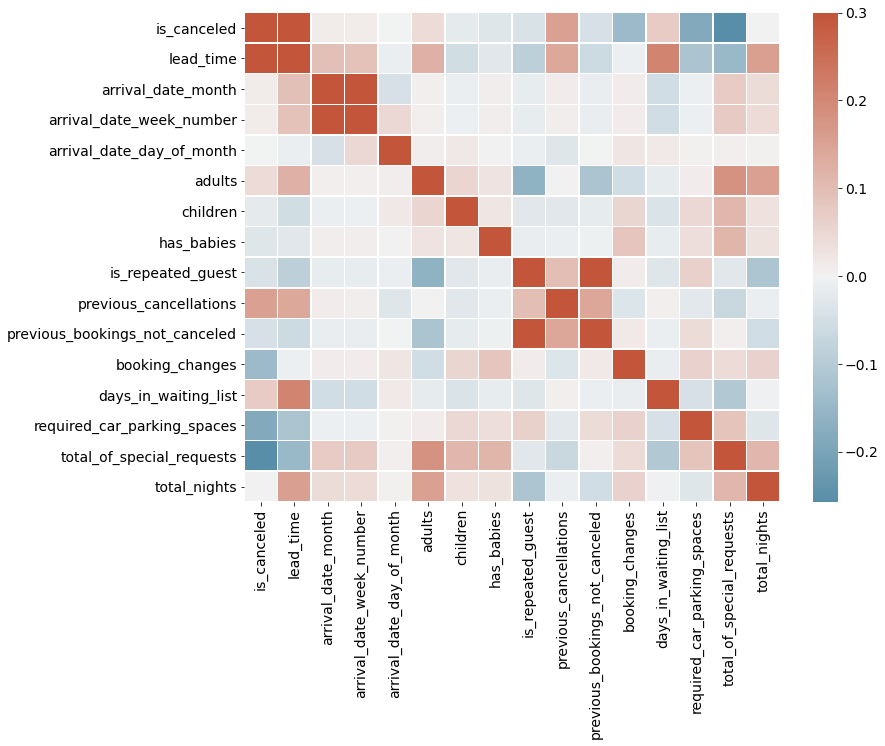

In [74]:
corr = df_train.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.3, center=0, cmap=cmap, linewidths=.5)
plt.show()

In [75]:
df_train.corr()['is_canceled'].abs().sort_values(ascending = False)

is_canceled                       1.000000
lead_time                         0.328142
total_of_special_requests         0.257061
required_car_parking_spaces       0.186486
previous_cancellations            0.153023
booking_changes                   0.142935
days_in_waiting_list              0.075848
previous_bookings_not_canceled    0.045557
adults                            0.044592
is_repeated_guest                 0.040242
has_babies                        0.032413
children                          0.017746
arrival_date_month                0.014626
arrival_date_week_number          0.012869
arrival_date_day_of_month         0.001903
total_nights                      0.001542
Name: is_canceled, dtype: float64

Наибольшую взаимосвязь имеют признаки `lead_time`, `total_of_special_requests` и `required_car_parking_spaces`. Наименьшую имеют `total_nights` и `arrival_date_day_of_month`.

### Обработка категориальных и числовых данных

Преобразуем категориальные признаки в численные техникой прямого кодирования (One-Hot Encoding, OHE) для линейной модели, а для деревьев порядковым кодированием - OrdinalEncoder.

In [76]:
df_train_ohe = pd.get_dummies(df_train, drop_first=True)
df_test_ohe = pd.get_dummies(df_test, drop_first=True)

In [77]:
df_train_ohe.head(2)

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,has_babies,is_repeated_guest,previous_cancellations,...,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,7,7,27,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,14,7,27,1,2,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [78]:
df_test_ohe.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,has_babies,is_repeated_guest,previous_cancellations,...,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,74,1,1,1,2,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,1,62,1,1,1,2,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,1,62,1,1,1,2,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,1,71,1,1,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,1,172,1,1,1,2,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [79]:
cat_filter = df_train.select_dtypes(include=object).columns
num_filter = df_train.select_dtypes(include='number').columns

In [80]:
enc = OrdinalEncoder()

In [81]:
enc.fit(df_train[cat_filter])

OrdinalEncoder()

In [82]:
df_train_cat = pd.DataFrame(enc.transform(df_train[cat_filter]), columns=cat_filter)
df_test_cat = pd.DataFrame(enc.transform(df_test[cat_filter]), columns=cat_filter)

In [83]:
df_train_cat.head(3)

,meal,country,distribution_channel,reserved_room_type,customer_type
0,0.0,5.0,1.0,0.0,2.0
1,0.0,5.0,3.0,0.0,2.0
2,0.0,9.0,1.0,2.0,2.0


In [84]:
df_train_ord = pd.concat([df_train[num_filter], df_train_cat], axis=1)
df_test_ord = pd.concat([df_test[num_filter], df_test_cat], axis=1)

In [85]:
df_train_ord.head(3)

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,has_babies,is_repeated_guest,previous_cancellations,...,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights,meal,country,distribution_channel,reserved_room_type,customer_type
0,0,7,7,27,1,1,0,0,0,0,...,0,0,0,0,1,0.0,5.0,1.0,0.0,2.0
1,0,14,7,27,1,2,0,0,0,0,...,0,0,0,1,2,0.0,5.0,3.0,0.0,2.0
2,0,0,7,27,1,2,0,0,0,0,...,0,0,0,0,2,0.0,9.0,1.0,2.0,2.0


Разделим данные по признакам - общие и целевые

In [86]:
features_train_ohe, target_train_ohe = df_train_ohe.drop('is_canceled', axis=1), df_train_ohe['is_canceled']
features_test_ohe, target_test_ohe = df_test_ohe.drop('is_canceled', axis=1), df_test_ohe['is_canceled']

In [87]:
features_train_ord, target_train_ord = df_train_ord.drop('is_canceled', axis=1), df_train_ord['is_canceled']
features_test_ord, target_test_ord = df_test_ord.drop('is_canceled', axis=1), df_test_ord['is_canceled']

Посмотрим на дисперсию и нормализуем числовые данные.

In [88]:
numeric = [
    'lead_time', 'arrival_date_week_number',
    'arrival_date_day_of_month', 'adults', 'children', 'has_babies',
    'previous_cancellations', 'previous_bookings_not_canceled',
    'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces',
    'total_of_special_requests', 'total_nights'
]

In [89]:
features_train_ohe[numeric].var()

lead_time                         9240.504839
arrival_date_week_number           181.279951
arrival_date_day_of_month           76.530696
adults                               0.222251
children                             0.111718
has_babies                           0.006882
previous_cancellations               0.931854
previous_bookings_not_canceled       1.759968
booking_changes                      0.352643
days_in_waiting_list               332.683218
required_car_parking_spaces          0.053868
total_of_special_requests            0.566392
total_nights                         3.021020
dtype: float64

In [90]:
hi_numeric = [
    'lead_time', 'arrival_date_week_number',
    'arrival_date_day_of_month', 'days_in_waiting_list'
]

In [91]:
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train_ohe[hi_numeric])

features_train_ohe[hi_numeric] = scaler.transform(features_train_ohe[hi_numeric])
features_test_ohe[hi_numeric] = scaler.transform(features_test_ohe[hi_numeric])

features_train_ord[hi_numeric] = scaler.transform(features_train_ord[hi_numeric])
features_test_ord[hi_numeric] = scaler.transform(features_test_ord[hi_numeric])

In [92]:
features_train_ohe.head(3)

,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,has_babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.929376,7,-0.322326,-1.697258,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,-0.856555,7,-0.322326,-1.697258,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,-1.002196,7,-0.322326,-1.697258,2,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [93]:
features_train_ohe[numeric].var()

lead_time                         1.000015
arrival_date_week_number          1.000015
arrival_date_day_of_month         1.000015
adults                            0.222251
children                          0.111718
has_babies                        0.006882
previous_cancellations            0.931854
previous_bookings_not_canceled    1.759968
booking_changes                   0.352643
days_in_waiting_list              1.000015
required_car_parking_spaces       0.053868
total_of_special_requests         0.566392
total_nights                      3.021020
dtype: float64

### Краткий вывод

Пропуски и явные дубликаты отсутствуют. Привели данные к правильным типам.
Проверилии данные на неявные дубликаты и возможные ошибки в категориальных признаках.
Заметили и исправили в колонках meal и reserved_room_type много лишних пробелов в данных, а так же неявные дубликаты.

Перевели месяцы из категориального в целочисленный тип.
В данных по странам, чтобы не плодить огромное количество лишних категорий оставили топ-10 значений, а остальные перевели в одну категорию - other.

Проверили количество отмен по разным категориям данных.
Если заказ не подтвержден в первые дни, то отмен в два раза больше. Если время между бронированием и датой заезда больше 90 суток, то процент отмен увеличивается пропорционально. Если у клиента есть отменённые заказы, то вероятность отмены почти 95%. Больше всего отмен у клиентов из Португалии. Кто дополнительно заказывал паркинг - вообще не отменяли бронь.
Если есть дополнительные опции/отметки то отмен всего ~20%

Проверили сбалансированность классов в таргете. Имеем небольшой дисбаланс классов 63/37.
Удалили малоинформативные не нужные для обучения модели признаки id, arrival_date_year, stays_in_week_nights и stays_in_weekend_nights.

Проверили корреляцию признаков. Наибольшую взаимосвязь имеют признаки lead_time, total_of_special_requests и required_car_parking_spaces. Наименьшую имеют total_nights и arrival_date_day_of_month.

Преобразовали категориальные признаки в численные техникой прямого кодирования и порядкового для разных моделей..
Разделили данные по признакам на общие и целевые.
Проверили дисперсию и сделали нормализацию числовых данные.

## Формулировка ML-задачи на основе бизнес-задачи

Рассчитаем и оценим прибыль отеля без внедрения депозитов. Напишем формулу для рассчета прибыли.

In [94]:
night_price = {
    'A': 1000, 'B': 800, 'C': 600, 'D': 550,
    'E': 500, 'F': 450, 'G': 350
}

In [95]:
clean_price = {
    'A': 400, 'B': 350, 'C': 350, 'D': 150,
    'E': 150, 'F': 150, 'G': 150
}

In [96]:
spring_autumn_mounth = [3, 4, 5, 9, 10, 11]

In [97]:
summer_mounth = [6, 7, 8]

In [98]:
def update_price(data, cf):
    for k in data.keys():
        data[k] *= cf

In [99]:
def income_calc(row, predict=False):
    room_type = row['reserved_room_type']
    s_night_price = night_price.copy()
    
    if row['arrival_date_month'] in spring_autumn_mounth:
        update_price(s_night_price, 1.2)
    elif row['arrival_date_month'] in summer_mounth:
        update_price(s_night_price, 1.4) 

    if row['is_canceled'] == 0:
        result = (
            row['total_nights'] 
            * s_night_price[room_type] 
            - clean_price[room_type] 
            - (row['total_nights'] // 2 * clean_price[room_type])
        )
    elif predict and row['is_canceled'] == 1 and row['predict_is_canceled'] == 1:
        result = (s_night_price[room_type] + clean_price[room_type]) * -0.2
    else:
        result = (s_night_price[room_type] + clean_price[room_type]) * -1
    return int(result)

In [100]:
df_test['income'] = df_test.apply(income_calc, axis=1)

In [101]:
df_test.head()

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,has_babies,meal,country,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,income
0,1,74,1,1,1,2,0,0,BB,PRT,...,0,0,A,0,0,Transient,0,0,1,-1400
1,1,62,1,1,1,2,0,0,BB,other,...,0,0,A,0,0,Transient,0,1,4,-1400
2,1,62,1,1,1,2,0,0,BB,other,...,0,0,A,0,0,Transient,0,1,4,-1400
3,1,71,1,1,1,1,0,0,BB,PRT,...,0,0,A,0,0,Transient,0,1,4,-1400
4,1,172,1,1,1,2,0,0,BB,BEL,...,0,0,A,0,0,Transient,0,0,7,-1400


In [102]:
df_test['income'].sum()

32582905

Прибыль отеля без внедрения депозитов на тестовых данных составила 32 582 905 руб.

## Разработка модели ML

### Обучение модели

Обучим разные модели и оценим их качество кросс-валидацией. Выберем лучшую модель. Для оценки моделей будем использовать метрику f1-score. 

Для нас важны Recall и Precision, они оценивают качество прогноза положительного класса с разных позиций - полноты и точности. 
Важны обе метрики. Оценивать их параллельно поможет f1-score. 

Модель **Logistic Regression**

In [103]:
%%time
log_model = LogisticRegression(random_state=33, solver='lbfgs', max_iter=1000)
scores = cross_val_score(log_model, features_train_ohe, target_train_ohe, cv=10, scoring='f1')
print('Средняя оценка качества модели LR на данных OHE:', scores.mean())

Средняя оценка качества модели LR на данных OHE: 0.6381550466363279
CPU times: user 3min 35s, sys: 3min 8s, total: 6min 44s
Wall time: 6min 45s


Модель **Decision Tree Classifier**

In [104]:
%%time
tree_model = DecisionTreeClassifier(random_state=33)
scores = cross_val_score(tree_model, features_train_ord, target_train_ord, cv=20, scoring='f1') 
print('Средняя оценка качества модели DT на данных ORD:', scores.mean())

Средняя оценка качества модели DT на данных ORD: 0.49556393793246595
CPU times: user 4.87 s, sys: 0 ns, total: 4.87 s
Wall time: 4.9 s


Модель **Random Forest Classifier**

In [105]:
%%time
rf_model = RandomForestClassifier(random_state=33)
scores = cross_val_score(rf_model, features_train_ord, target_train_ord, cv=20, scoring='f1')
print('Средняя оценка качества модели RFна данных ORD:', scores.mean())

Средняя оценка качества модели RFна данных ORD: 0.501949206573654
CPU times: user 1min 37s, sys: 611 ms, total: 1min 37s
Wall time: 1min 38s


Лучшую среднюю оценку показала модель Logistic Regression. Попробуем улучшить метрику у "деревянных" моделей с помощью подбора параметров.

In [106]:
%%time
param = {
    'max_depth': [6, 8, 12],
    'min_samples_split': [2],
    'max_features': [6, 8, 12],
    'class_weight': ['balanced']
}

clf = GridSearchCV(tree_model, param, scoring='f1', cv=10, n_jobs=-1)
clf.fit(features_train_ord, target_train_ord)

tree_model = clf.best_estimator_
print('Лучшие параметры:', clf.best_params_)
print('Best score:', clf.best_score_)

Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 6, 'max_features': 8, 'min_samples_split': 2}
Best score: 0.6514647370065734
CPU times: user 7.14 s, sys: 0 ns, total: 7.14 s
Wall time: 7.15 s


In [107]:
%%time
param = {
    'n_estimators': [50],
    'max_depth': [6, 8],
    'min_samples_split': [2],
    'max_features': [8, 12],
    'class_weight': ['balanced']
}

clf = GridSearchCV(rf_model, param, scoring='f1', cv=20, n_jobs=-1)
clf.fit(features_train_ord, target_train_ord)

rf_model = clf.best_estimator_
print('Лучшие параметры:', clf.best_params_)
print('Best score:', clf.best_score_)

Лучшие параметры: {'class_weight': 'balanced', 'max_depth': 8, 'max_features': 12, 'min_samples_split': 2, 'n_estimators': 50}
Best score: 0.6829174138154538
CPU times: user 2min 51s, sys: 0 ns, total: 2min 51s
Wall time: 2min 52s


После подбора параметров лучший f1-score показала Random Forest. Возьмем ее для для проверки на тестовой выборке.

Напишем функцию отображения ROC-кривой.

In [108]:
def draw_roc(fpr, tpr):
    plt.figure(figsize=(8, 6))
    plt.plot([0, 1], [0, 1], linestyle='--',)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

### Тестирование модели

Проверим модель на тестовых данных.

In [109]:
rf_model.fit(features_train_ord, target_train_ord)
predict_test = rf_model.predict(features_test_ord)
print('f1 метрика на тестовых данных RF:', f1_score(target_test_ord, predict_test))

f1 метрика на тестовых данных RF: 0.681845953321657


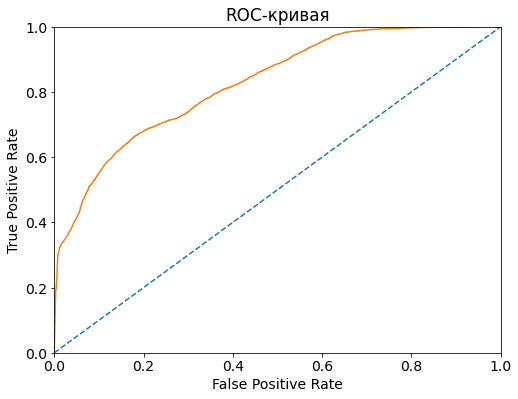

roc-auc score: 0.7418197549988047


In [110]:
predict_proba_one = rf_model.predict_proba(features_test_ord)[:, 1]
fpr, tpr, thresholds = roc_curve(target_test_ord, predict_proba_one)

draw_roc(fpr, tpr)
print('roc-auc score:', roc_auc_score(target_test_ord, predict_test))

### Оценка прибыли

Оценим прибыль, которую принесёт выбранная модель за тестовый период.

In [111]:
df_test['predict_is_canceled'] = predict_test

In [112]:
df_test['income_predict'] = df_test.apply(income_calc, predict=True, axis=1)

In [113]:
df_test.head(2)

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,has_babies,meal,country,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,income,predict_is_canceled,income_predict
0,1,74,1,1,1,2,0,0,BB,PRT,...,A,0,0,Transient,0,0,1,-1400,1,-280
1,1,62,1,1,1,2,0,0,BB,other,...,A,0,0,Transient,0,1,4,-1400,0,-1400


In [114]:
df_test.query('is_canceled == 0').head(2)

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,adults,children,has_babies,meal,country,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,income,predict_is_canceled,income_predict
95,0,0,1,4,25,1,0,0,BB,PRT,...,A,0,0,Transient,0,0,1,600,0,600
299,0,70,2,8,22,2,0,0,BB,GBR,...,A,2,0,Transient-Party,0,0,4,2800,0,2800


In [115]:
income_sum = df_test['income'].sum()
income_predict_sum = df_test['income_predict'].sum()

In [116]:
print('Прибыль без предсказаний:', income_sum)
print('Прибыль с предсказаниями отмены:', income_predict_sum)

Прибыль без предсказаний: 32582905
Прибыль с предсказаниями отмены: 42356377


In [117]:
print('Выручка от введения системы прогнозирования:', income_predict_sum - income_sum - 400_000)

Выручка от введения системы прогнозирования: 9373472


Депозит для «надежных» клиентов может их отпугнуть. Попробуем проверить такой сценарий, назовем его худшим: пусть половина случайных клиентов из тех, с кого модель предложит взять депозит, откажутся от услуг.

In [118]:
def random_drop(row):
    res = row['income_predict']
    if np.random.randint(2) == 1:
        if row['predict_is_canceled'] == 1:
            res = 0
    return res

In [119]:
df_test['drop_income'] = df_test.apply(random_drop, axis=1)

In [120]:
drop_income = df_test['drop_income'].sum()

In [121]:
print('Прибыль, если 50% откажутся от заказа с предложенным депозитом:', drop_income)

Прибыль, если 50% откажутся от заказа с предложенным депозитом: 38603111


In [122]:
print('Выручка от введения системы прогнозирования с "плохим" исходом:', income_predict_sum - drop_income - 400_000)

Выручка от введения системы прогнозирования с "плохим" исходом: 3353266


Как можно заметить, даже при "плохом" сценарии прибыль составляет 3 353 266 руб.

### Краткий вывод

Рассчитали и оценили прибыль отеля без внедрения депозитов. Прибыль отеля без внедрения депозитов на тестовых данных составила 32 582 905 руб.

Обучили разные модели и оценили их f1-score кросс-валидацией:
- модель Logistic Regression - средняя оценка: 0.64
- модель Decision Tree Classifier - средняя оценка: 0.50
- модель Random Forest Classifier - средняя оценка: 0.50

Лучшую среднюю оценку показала модель LogReg. Eлучшили метрику у "деревянных" моделей с помощью подбора параметров. После подбора параметров лучший f1-score показала Random Forest - 0.68.

Проверили модель на тестовых данных. f1 метрика на тестовых данных составила: 0.682, а roc-auc score: 0.741.

Оценили прибыль, которую принесёт выбранная модель за тестовый период.<br>
Прибыль без предсказаний: 32 582 905 руб.<br>
Прибыль с предсказаниями отмены: 42 356 377 руб.<br>
Выручка от введения системы прогнозирования: 9 373 472 руб.<br>

Даже при плохом сценарии, если половина «надежных» случайных клиентов из тех, с кого модель предложит взять депозит, откажутся от услуг прибыль составит 3 353 266 руб.

## Портрет «ненадёжного» клиента

На основе исследовательского анализа данных описать клиента, склонного к отказу от брони можно так:
- если клиент заказ не подтверждил в первые дни, то отмен в два раза больше.
- чем больше дней (90+) между бронью и датой заезда, тем больше вероятность отмены.
- если у клиента есть отменённые заказы, то вероятность отмены почти 95%.
- больше всего отмен у клиентов из Португалии.
- не заказывает паркинг (кто дополнительно заказывал паркинг - вообще не отменяли бронь).
- нет доп. опций/заметок/запросов (если есть дополнительные опции/отметки то отмен всего ~20%).

По остальным признакам показатели в пределах общего баланса классов 60/40.

## Общий вывод

Опишите модель, которая решает задачу с наибольшей выгодой для бизнеса. 
Дайте бизнесу рекомендации по результатам проделанной работы.

Открыли фалйы и загрузили данные, пропуски и явные дубликаты отсутствуют. Привели данные к правильным типам. Проверилии данные на неявные дубликаты и возможные ошибки в категориальных признаках. Заметили и исправили в колонках meal и reserved_room_type много лишних пробелов в данных, а так же неявные дубликаты.

Перевели месяцы из категориального в целочисленный тип. В данных по странам, чтобы не плодить огромное количество лишних категорий оставили топ-10 значений, а остальные перевели в одну категорию - other.

Проверили количество отмен по разным категориям данных. Если заказ не подтвержден в первые дни, то отмен в два раза больше. Если время между бронированием и датой заезда больше 90 суток, то процент отмен увеличивается пропорционально. Если у клиента есть отменённые заказы, то вероятность отмены почти 95%. Больше всего отмен у клиентов из Португалии. Кто дополнительно заказывал паркинг - вообще не отменяли бронь.
Если есть дополнительные опции/отметки то отмен всего ~20%

Проверили сбалансированность классов в таргете. Имеем небольшой дисбаланс классов 63/37. Удалили малоинформативные не нужные для обучения модели признаки id, arrival_date_year, stays_in_week_nights и stays_in_weekend_nights.

Проверили корреляцию признаков. Наибольшую взаимосвязь имеют признаки lead_time, total_of_special_requests и required_car_parking_spaces. Наименьшую имеют total_nights и arrival_date_day_of_month.

Преобразовали категориальные признаки в численные техникой прямого кодирования (One-Hot Encoding, OHE). Разделили данные по признакам на общие и целевые, а так же на тренировочную и валидационную выборки. Проверили дисперсию и сделали нормализацию числовых данные.

Рассчитали и оценили прибыль отеля без внедрения депозитов. Прибыль отеля без внедрения депозитов на тестовых данных составила 32 582 905 руб.

Обучили разные модели и оценили их f1-score кросс-валидацией:
- модель Logistic Regression - средняя оценка: 0.64
- модель Decision Tree Classifier - средняя оценка: 0.50
- модель Random Forest Classifier - средняя оценка: 0.50

Лучшую среднюю оценку показала модель LogReg. Eлучшили метрику у "деревянных" моделей с помощью подбора параметров. После подбора параметров лучший f1-score показала Random Forest - 0.68.

Проверили модель на тестовых данных. f1 метрика на тестовых данных составила: 0.682, а roc-auc score: 0.741.

Оценили прибыль, которую принесёт выбранная модель за тестовый период.<br>
Прибыль без предсказаний: 32 582 905 руб.<br>
Прибыль с предсказаниями отмены: 42 356 377 руб.<br>
Выручка от введения системы прогнозирования: 9 373 472 руб.<br>

Даже при плохом сценарии, если половина «надежных» случайных клиентов из тех, с кого модель предложит взять депозит, откажутся от услуг прибыль составит 3 353 266 руб.

По итоговым результатам работы можно дать бизнесу рекомендации по внедрению модели предсказаний отмены брони. Модель Random Forest Classifier дает лучшие результаты и емеет потенциал для более детальной настройки и улучшению показателей.